In [12]:
################################################################################
# This notebook contains the code used for the evaluation of PCA, t-SNE and UMAP
# as well as the code for the visualisations of t-SNE and UMAP
################################################################################

import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
from sklearn.manifold import TSNE
import seaborn as sns
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean
 
dbpath = r"./featuresPML2/"
 
def load_data(dbpath):
    data = []
    data_path = []
    for class_folder in os.listdir(dbpath):
        class_folder_path = os.path.join(dbpath, class_folder)
        for obj_file_path in glob.glob(os.path.join(class_folder_path, '*')):
            imp = np.load(obj_file_path, allow_pickle=True)
            data.append(imp)
            data_path.append(obj_file_path)
    return data, data_path
 
data, paths = load_data(dbpath)

classes = []
for i in paths:
    classes.append(i.split("/")[2].split("\\")[0])

print(classes)

def standardize_cols(matrix, cols):
    rows = len(matrix)
    for col in cols:
        col_total = np.zeros((rows))
        for row in range(rows):
            try:
                col_total[row] = matrix[row][col]
            except:
                print(row)
        std = np.std(col_total)
        mean = np.mean(col_total)
        for row in range(rows):
            matrix[row][col] = (matrix[row][col] - mean) / std
    return matrix
 
scalar_indexes = [0, 1, 2, 3, 4, 13, 14, 15, 16, 17, 18, 19, 20]
hist_indexes = [5, 6, 7, 8, 9, 10, 11, 12]
 
data = standardize_cols(data, scalar_indexes)

new_db = []
for i in data:
    new = i[0:5]
    for j in i[5:13]:
        new = np.append(new, j)
    new = np.append(new,i[13:])
    new_db.append(new)

print("feature vector length:", len(new_db[0]))

['AircraftBuoyant', 'AircraftBuoyant', 'AircraftBuoyant', 'AircraftBuoyant', 'AircraftBuoyant', 'AircraftBuoyant', 'AircraftBuoyant', 'AircraftBuoyant', 'AircraftBuoyant', 'AircraftBuoyant', 'AircraftBuoyant', 'AircraftBuoyant', 'AircraftBuoyant', 'AircraftBuoyant', 'AircraftBuoyant', 'AircraftBuoyant', 'Apartment', 'Apartment', 'Apartment', 'Apartment', 'Apartment', 'Apartment', 'Apartment', 'Apartment', 'Apartment', 'Apartment', 'Apartment', 'Apartment', 'Apartment', 'Apartment', 'Apartment', 'Apartment', 'Apartment', 'Apartment', 'Apartment', 'Apartment', 'Apartment', 'Apartment', 'Apartment', 'AquaticAnimal', 'AquaticAnimal', 'AquaticAnimal', 'AquaticAnimal', 'AquaticAnimal', 'AquaticAnimal', 'AquaticAnimal', 'AquaticAnimal', 'AquaticAnimal', 'AquaticAnimal', 'AquaticAnimal', 'AquaticAnimal', 'AquaticAnimal', 'AquaticAnimal', 'AquaticAnimal', 'AquaticAnimal', 'AquaticAnimal', 'AquaticAnimal', 'AquaticAnimal', 'AquaticAnimal', 'AquaticAnimal', 'AquaticAnimal', 'AquaticAnimal', 'Aqua

In [13]:
# make pandas datframe of feature vectors and copy frame to add labels for visualisation
test_db = pd.DataFrame(new_db)
test_db_results = pd.DataFrame(new_db)
test_db_results["category"] = classes
#print(test_db_results)

In [14]:
# PCA 
# compute PCA for feature vectors 1038D -> 2D, and check accuracy for these 2D vectors with euclidean distance
pca = PCA(n_components=2)
pca.fit(test_db)
X_pca = pca.transform(test_db)
X_new = pca.inverse_transform(X_pca)

PCA_results = X_new[:,:2]

# Save results
all_results = []
for i in range(len(PCA_results)):
    distances = [euclidean(PCA_results[i], res) for res in PCA_results]
    result = list(zip(distances, paths))
    result.sort(key=lambda x: x[0])
    all_results.append(result)
 
 
data_file = open("./resultsPCA.npy", "wb")
np.save(data_file, np.asarray(all_results, dtype="object"))
data_file.close()

In [15]:
# Compute t-SNE to reduce dimensions from 1038 -> 2, and compute accuracy based on matching with eaclidian distance,
# perplexity 20 yields best results
# after 450 iterations accuracy does not improve anymore

# Compute t-SNE
test_db = pd.DataFrame(new_db)

tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=450)
tsne_results = tsne.fit_transform(test_db)
 
test_db_results['tsne-2d-one'] = tsne_results[:,0]
test_db_results['tsne-2d-two'] = tsne_results[:,1]

tsne_results = tsne_results[:,:2]
print("t-SNE finsished")

# Save results
all_results = []
for i in range(len(tsne_results)):
    distances = [euclidean(tsne_results[i], res) for res in tsne_results]
    result = list(zip(distances, paths))
    result.sort(key=lambda x: x[0])
    all_results.append(result)
 
 
data_file = open("./resultsTSNe.npy", "wb")
np.save(data_file, np.asarray(all_results, dtype="object"))
data_file.close()



[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 2466 samples in 0.015s...
[t-SNE] Computed neighbors for 2466 samples in 0.433s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2466
[t-SNE] Computed conditional probabilities for sample 2000 / 2466
[t-SNE] Computed conditional probabilities for sample 2466 / 2466
[t-SNE] Mean sigma: 0.870081
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.853516
[t-SNE] KL divergence after 450 iterations: 1.322885
t-SNE finsished


In [16]:
test_db = pd.DataFrame(new_db)

reducer = umap.UMAP(n_neighbors = 6)
scaled_data = StandardScaler().fit_transform(test_db)
embedding = reducer.fit_transform(scaled_data)
 
test_db_results['UMAP-2d-one'] = embedding[:,0]
test_db_results['UMAP-2d-two'] = embedding[:,1]

UMAP_results = embedding[:,:2]
print("UMAP finsished")

# Save results
all_results = []
for i in range(len(UMAP_results)):
    distances = [euclidean(UMAP_results[i], res) for res in UMAP_results]
    result = list(zip(distances, paths))
    result.sort(key=lambda x: x[0])
    all_results.append(result)
 
 
data_file = open("./resultsUMAP.npy", "wb")
np.save(data_file, np.asarray(all_results, dtype="object"))
data_file.close()



UMAP finsished


In [17]:
# show scatter plot of 2D obtained by t-SNE for all classes
fig = px.scatter(test_db_results, x="tsne-2d-one", y="tsne-2d-two",  log_x=False, color="category", width=1000, height=600)
fig.show()

In [18]:
# show scatter plot of 2D obtained by t-SNE for 8 good classes
cl = ["Bicycle", "Car", "Helicopter", "Humanoid", "Jet", "Knife", "MultiSeat", "NonWheelChair"]
mask = test_db_results["category"].isin(cl)
final_db = test_db_results[mask]

fig = px.scatter(final_db, x="tsne-2d-one", y="tsne-2d-two",  log_x=False, color="category", width=1000, height=600)
fig.show()

In [19]:
# show scatter plot of 2D obtained by t-SNE for 8 bas classes
cl = ["AircraftBuoyant", "BuildingNonResidential", "PlantWildNonTree", "Hand", "Tree", "Starship", "Ship", "Insect"]
mask = test_db_results["category"].isin(cl)
final_db = test_db_results[mask]

fig = px.scatter(final_db, x="tsne-2d-one", y="tsne-2d-two",  log_x=False, color="category", width=1000, height=600)
fig.show()

Text(0.5, 1.0, 'scatterplot of the two reduced dimensions obtained by t-SNE')

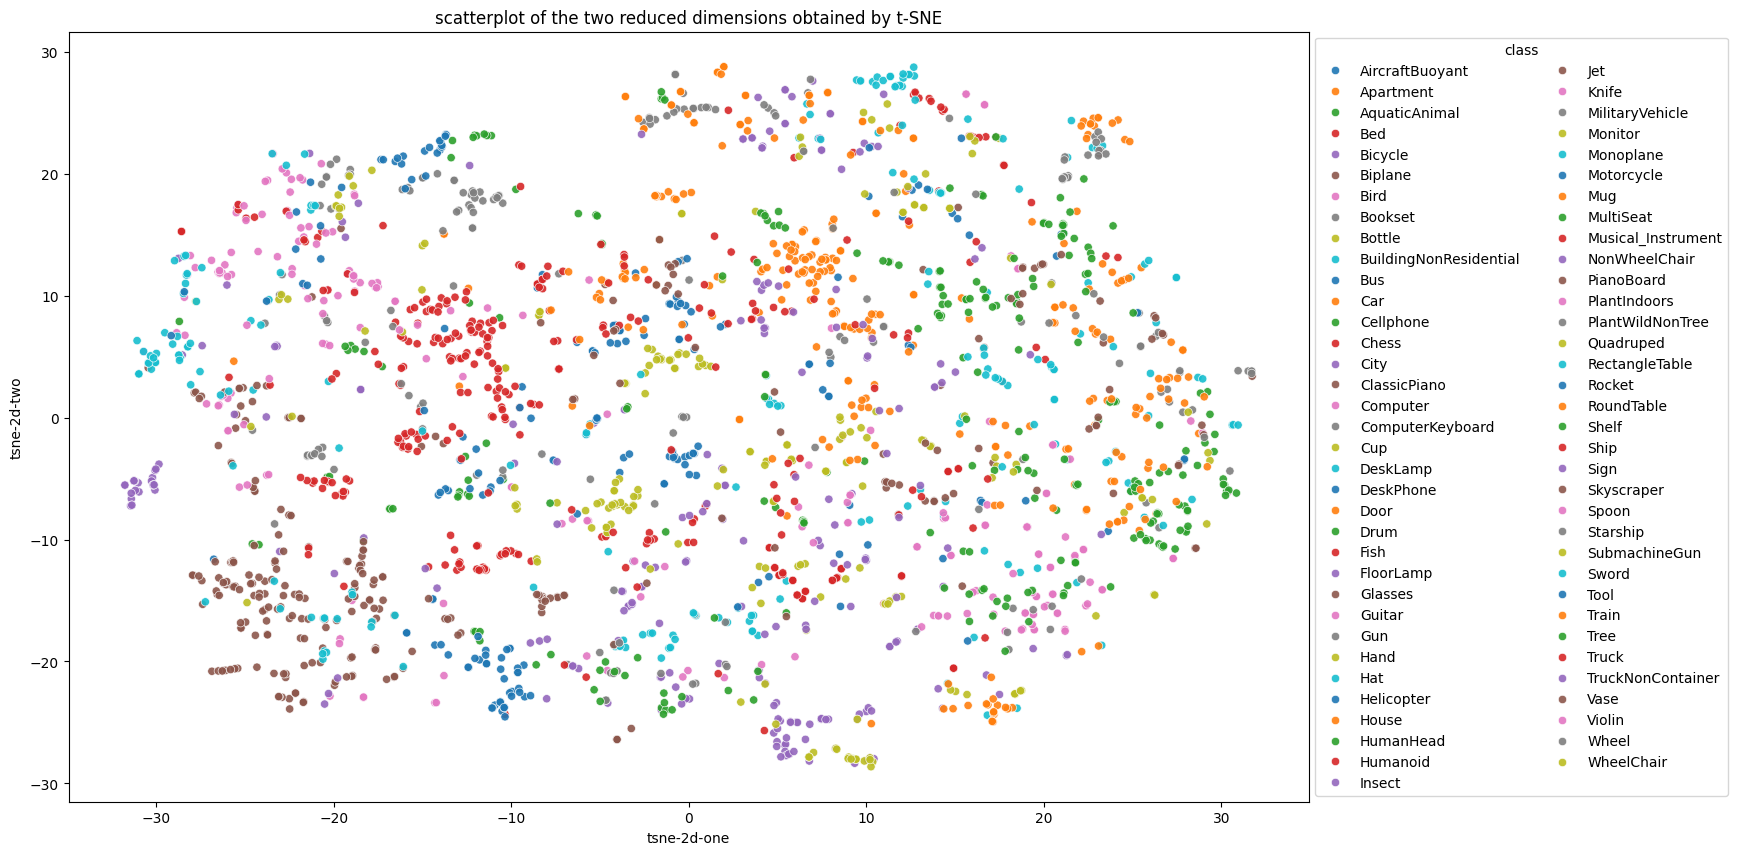

In [20]:
# show scatter plot of 2D obtained by t-SNE for all classes
plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="category",
    palette="tab10",
    data=test_db_results,
    legend="full",
    alpha=0.9
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, title = "class")
ax.set_title("scatterplot of the two reduced dimensions obtained by t-SNE")

In [21]:
# show scatter plot of 2D obtained by UMAP for all classes
fig = px.scatter(test_db_results, x="UMAP-2d-one", y="UMAP-2d-two",  log_x=False, color="category", width=1000, height=600)
fig.show()

Text(0.5, 1.0, 'scatterplot of the two reduced dimensions obtained by UMAP')

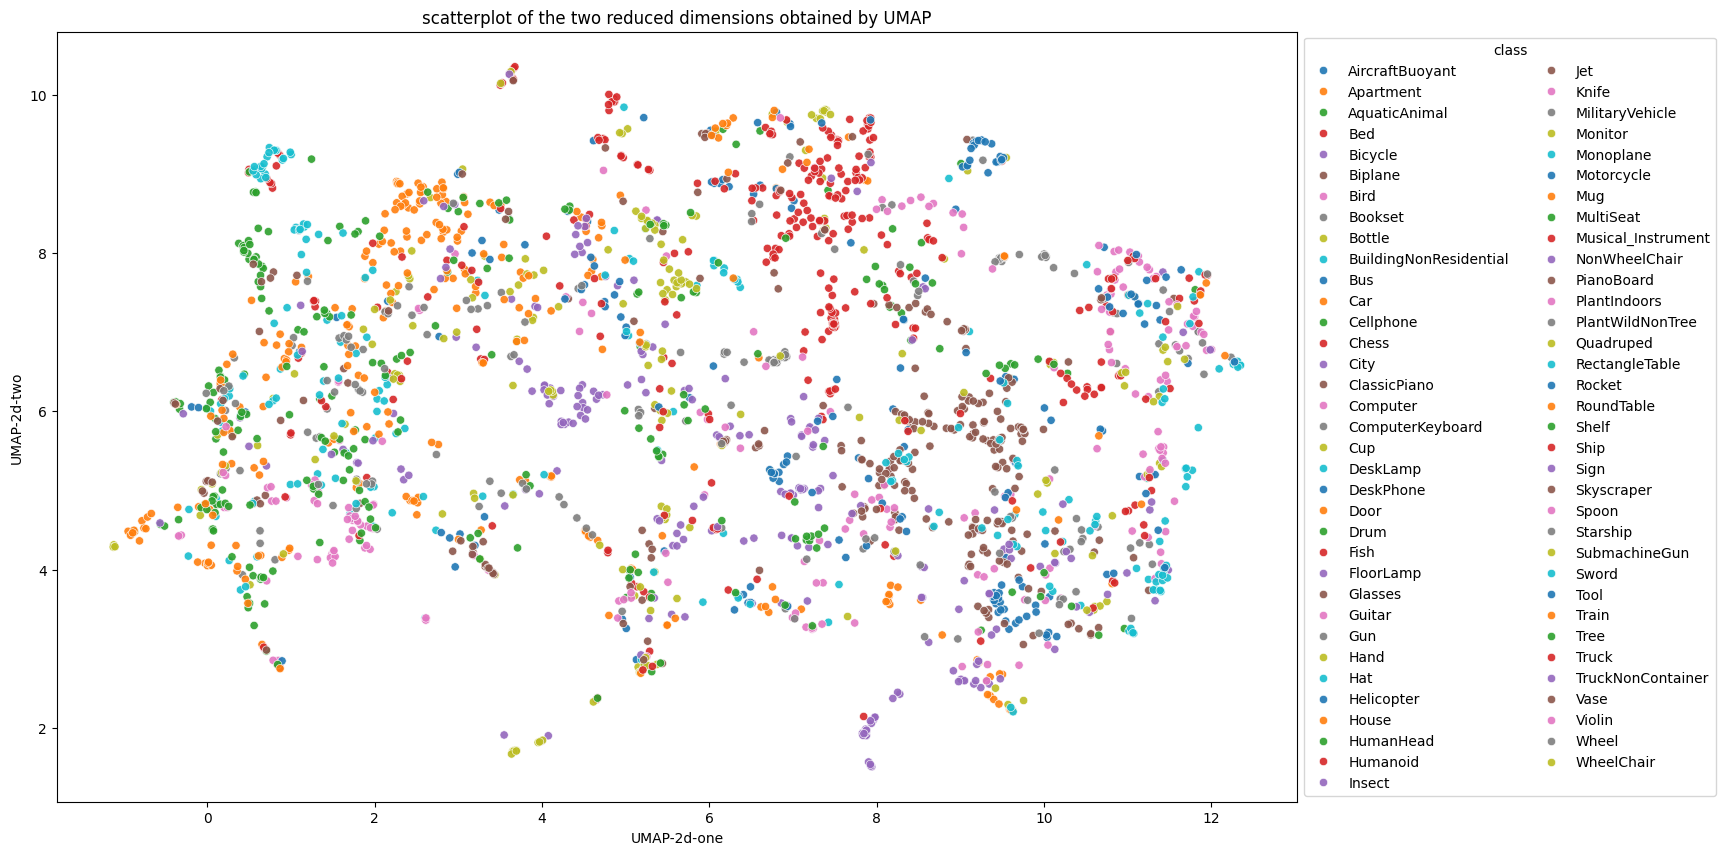

In [22]:
# show scatter plot of 2D obtained by UMAP for all classes
plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x="UMAP-2d-one", y="UMAP-2d-two",
    hue="category",
    palette="tab10",
    data=test_db_results,
    legend="full",
    alpha=0.9
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, title = "class")
ax.set_title("scatterplot of the two reduced dimensions obtained by UMAP")

#plt.setp(ax.get_legend().get_texts(), fontsize='10') # for legend text